# Project Overview

# Import Libraries

In [ ]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Lasso, Ridge, LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb

# Data

#### Download Data

In [2]:
# Download the competition data from kaggle
# ! kaggle competitions download -c riiid-test-answer-prediction -p ../../data

In [3]:
# Unzip the data
# with zipfile.ZipFile('../../data/riiid-test-answer-prediction.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data')

#### Import Data

In [4]:
# Import the data as Pandas DataFrames
train = pd.read_csv('../../data/train.csv')
questions = pd.read_csv('../../data/questions.csv')
lectures = pd.read_csv('../../data/lectures.csv')

#### Explore Data

In [ ]:
train.shape
# 101,230,332 rows

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
row_id                            int64
timestamp                         int64
user_id                           int64
content_id                        int64
content_type_id                   int64
task_container_id                 int64
user_answer                       int64
answered_correctly                int64
prior_question_elapsed_time       float64
prior_question_had_explanation    object
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


In [6]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [ ]:
# Class Imbalance
sns.set(context = 'notebook', style = 'whitegrid')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4)) 
ax1.hist(y, color = 'red', alpha = .5, bins = 5)
ax1.set_title('Class distribution')
ax2.hist(train['answered_correctly'], color = 'blue', alpha = .5, bins = 5)

### Prepare data for modeling

In [7]:
# Split data into features and target
X = train.drop('answered_correctly', axis=1)
y = train['answered_correctly']

In [8]:
# Train Test Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [14]:
# Pipeline for preprocessing numeric features
numeric_features = list(X.select_dtypes(exclude='object').columns)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline for preprocessing categorical features
categorical_features = list(X.select_dtypes(include='object').columns)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(fill_value=False)),
    ('one_hot_encoder', OneHotEncoder(sparse=False))])

# Pipeline for preprocessing combined
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [16]:
# Use preprocessing pipeline to transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Modeling

#### First Simple Model

In [17]:
fsm = LogisticRegression()
fsm.fit(X_train_transformed, y_train)

LogisticRegression()

In [19]:
# Score on our training data
y_pred = fsm.predict(X_train_transformed)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00   1469561
           0       0.52      0.07      0.13  25522298
           1       0.67      0.97      0.79  48930890

    accuracy                           0.67  75922749
   macro avg       0.73      0.68      0.64  75922749
weighted avg       0.62      0.67      0.57  75922749



In [20]:
# Score on our testing data
y_pred = fsm.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00    489471
           0       0.52      0.07      0.13   8504375
           1       0.67      0.97      0.79  16313737

    accuracy                           0.67  25307583
   macro avg       0.73      0.68      0.64  25307583
weighted avg       0.62      0.67      0.57  25307583



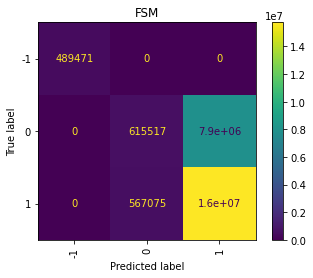

In [27]:
# Confusion matrix
plot_confusion_matrix(fsm, X_test_transformed, y_test)
plt.title('FSM')
plt.xticks(rotation='vertical');

### Further Data Preprocessing

#### Using Smote to Deal with Class Imbalance

In [ ]:
print("Before OverSampling, counts of label -1: {}".format(sum(y_train == -1))) 
print("Before OverSampling, counts of label 0: {}".format(sum(y_train == 0))) 
print("Before OverSampling, counts of label 1: {} \n".format(sum(y_train == 1))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
sm = SMOTE(random_state = 42) 
X_train_res, y_train_res = sm.fit_sample(X_train_transformed, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label -1: {}".format(sum(y_train_res == -1))) 
print("After OverSampling, counts of label 0".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label 1: {}".format(sum(y_train_res == 1)))

Before OverSampling, counts of label -1': 1469561
Before OverSampling, counts of label 0: 25522298
Before OverSampling, counts of label 1: 48930890 



In [ ]:
sns.set(context = 'notebook', style = 'whitegrid')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4)) 
ax1.hist(y, color = 'red', alpha = .5, bins = 5)
ax1.set_title('Class distribution before SMOTE')
ax2.hist(y_train_res, color = 'blue', alpha = .5, bins = 5)
ax2.set_title('Class distribution After SMOTE')
fig.tight_layout()
plt.savefig('../../reports/figures/Fixing_class_imbalance.jpg', bbox_inches='tight');